<a href="https://colab.research.google.com/github/sherin-joseph/ShapeAI_Python_Machine_Learning/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import requests
import os
os.makedirs("convergence_clustering/datasets/data", exist_ok=True)
os.makedirs("figs", exist_ok=True)
data_url = "https://megastore.rz.uni-augsburg.de/get/8D00AB7R__/"
plots_url = "https://megastore.rz.uni-augsburg.de/get/NLpL6ukys1/"
# Download datasets
data_response = requests.get(data_url)
with open("convergence_clustering/datasets/data/data.zip", "wb") as f:
    f.write(data_response.content)
    print("Datasets downloaded successfully.")
# Download plots
plots_response = requests.get(plots_url)
with open("figs/plots.zip", "wb") as f:
    f.write(plots_response.content)
    print("Plots downloaded successfully.")


Datasets downloaded successfully.
Plots downloaded successfully.


In [ ]:
!pip install torch torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 977.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.4 MB/s eta 0:00:00


In [ ]:
import torch

# Load the checkpoint
checkpoint = torch.load("/image_classifier_model.pth", map_location=torch.device('cpu'))

# Print the keys of the loaded dictionary
print(checkpoint.keys())


odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.3.weight', 'encoder.3.bias', 'decoder.1.weight', 'decoder.1.bias', 'decoder.4.weight', 'decoder.4.bias'])


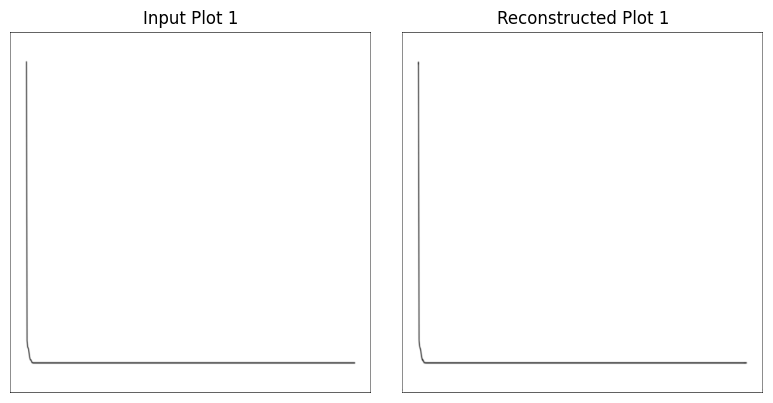

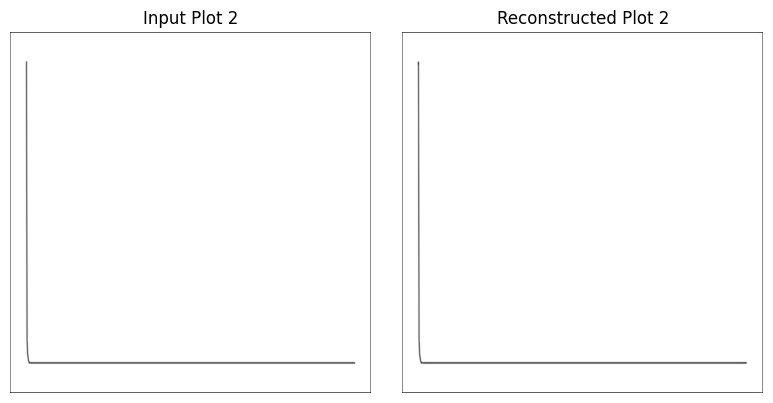

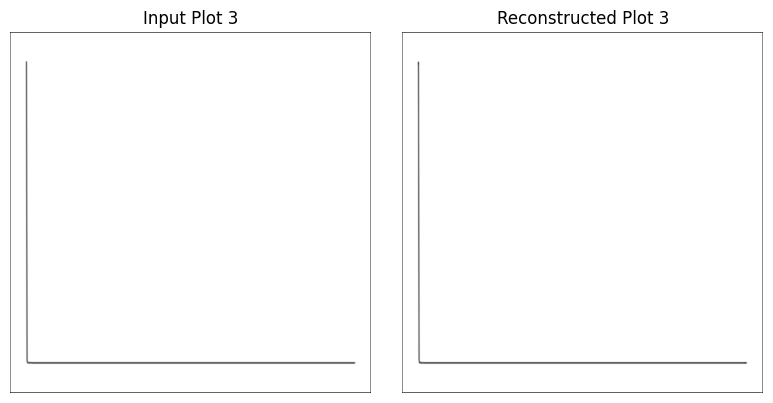

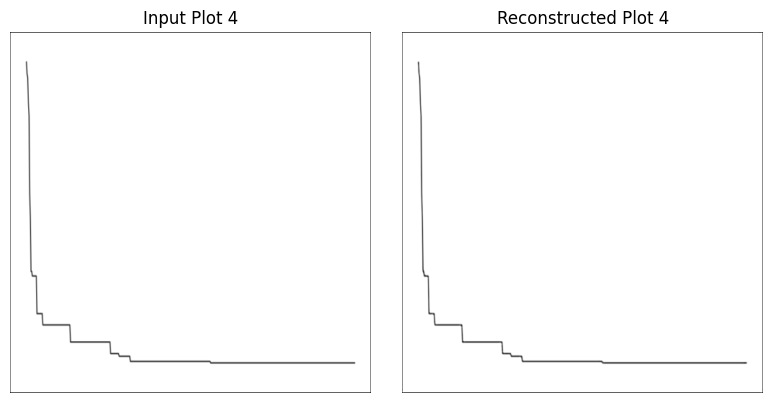

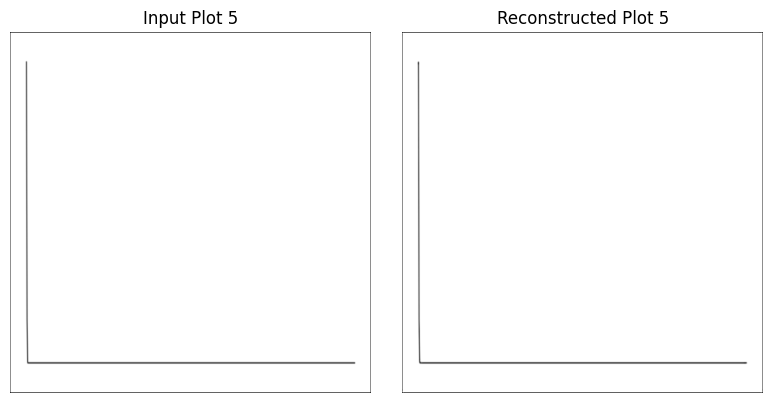

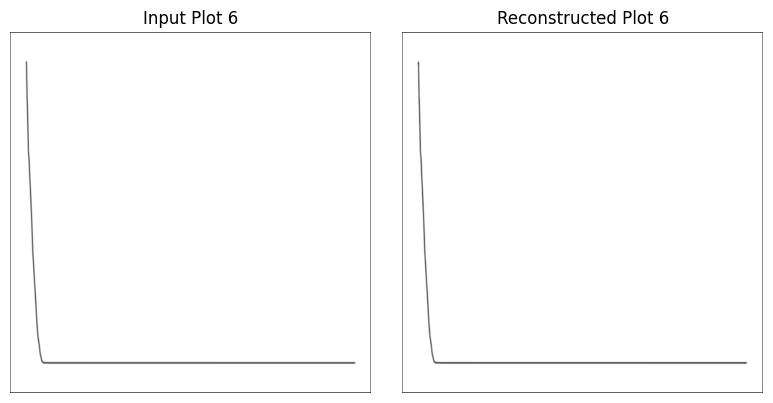

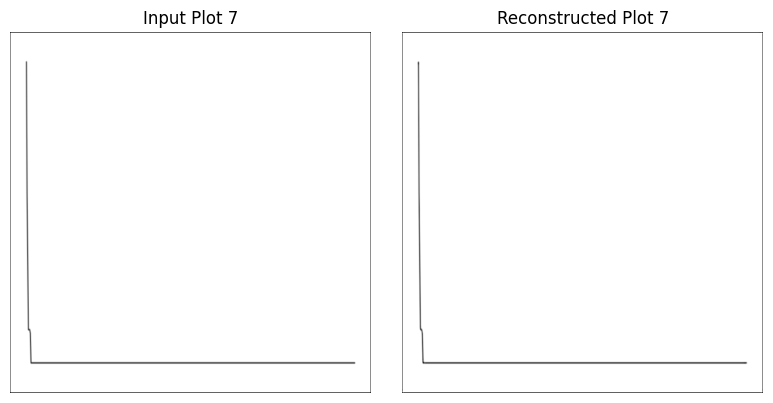

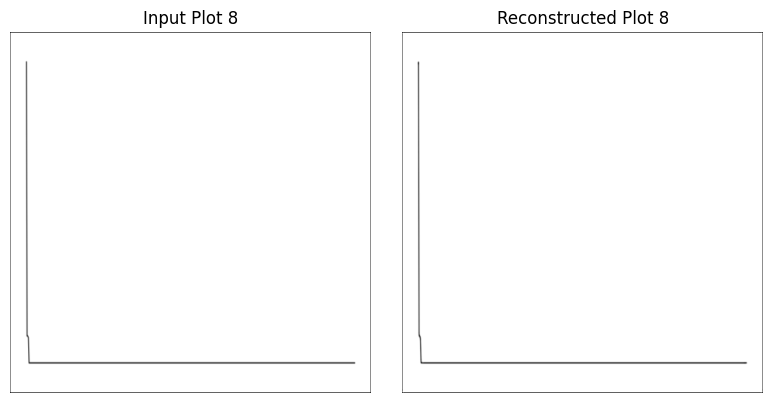

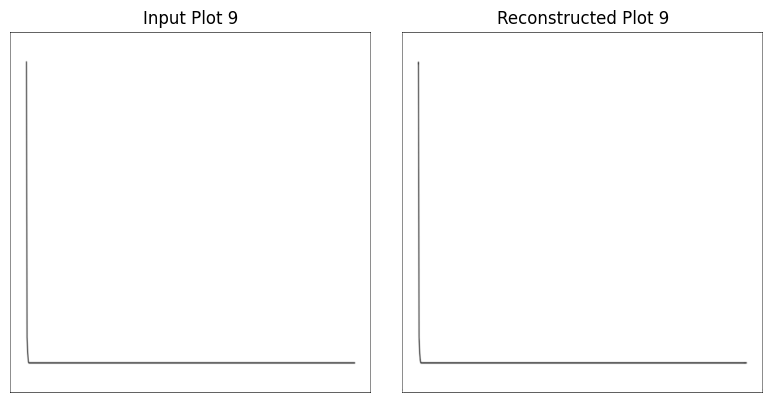

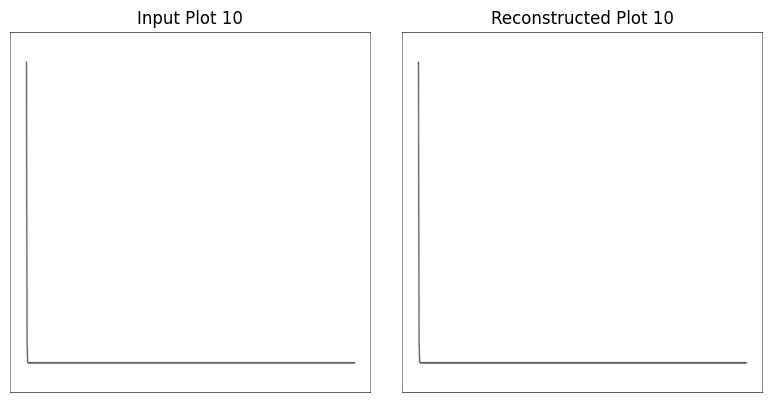

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import zipfile
import io
import random
import matplotlib.pyplot as plt

# Define the Autoencoder model architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 3, stride=1, padding=1),  #
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=1),
            torch.nn.Conv2d(64, 16, 3, stride=1, padding=1),  # b, 8, 3, 3
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=1, mode='nearest'),
            torch.nn.Conv2d(16, 64, 3, stride=1, padding=1),  # b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Upsample(scale_factor=1, mode='nearest'),
            torch.nn.Conv2d(64, 1, 3, stride=1, padding=2),  # b, 8, 3, 3
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



# Initialize the autoencoder model
model = Autoencoder()

# Load the pre-trained weights and biases
checkpoint = torch.load("/image_classifier_model.pth", map_location=torch.device('cpu'))

# Load weights and biases for encoder
model.encoder[0].weight = nn.Parameter(checkpoint['encoder.0.weight'])
model.encoder[0].bias = nn.Parameter(checkpoint['encoder.0.bias'])
model.encoder[3].weight = nn.Parameter(checkpoint['encoder.3.weight'])
model.encoder[3].bias = nn.Parameter(checkpoint['encoder.3.bias'])

# Load weights and biases for decoder if available
for i in range(len(model.decoder)):
    if f'decoder.{i}.weight' in checkpoint:
        model.decoder[i].weight = nn.Parameter(checkpoint[f'decoder.{i}.weight'])
    if f'decoder.{i}.bias' in checkpoint:
        model.decoder[i].bias = nn.Parameter(checkpoint[f'decoder.{i}.bias'])

# Set the model to evaluation mode
model.eval()

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((500, 500)),  # Resize to 500x500 pixels
    transforms.ToTensor(),  # Convert to tensor
])

# Load input plots from the zip file
input_zip_file = "/content/pl.zip"
input_plots = []
with zipfile.ZipFile(input_zip_file, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if file.endswith('.png'):
            with zip_ref.open(file) as image_file:
                img_data = io.BytesIO(image_file.read())
                img = Image.open(img_data)
                input_plots.append(transform(img).unsqueeze(0))  # Preprocess and add to list

# Pass input plots through the autoencoder to obtain reconstructed plots
with torch.no_grad():
    reconstructed_plots = [model(plot) for plot in input_plots]

# Choose a few input plots randomly for comparison
num_plots_to_compare = 10
random_indices = random.sample(range(len(input_plots)), num_plots_to_compare)

# Plot the selected input plots along with their reconstructed counterparts
for i, idx in enumerate(random_indices):
    input_plot = input_plots[idx].squeeze().numpy()
    reconstructed_plot = reconstructed_plots[idx].squeeze().numpy()

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(input_plot, cmap='gray')
    plt.title(f'Input Plot {i+1}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_plot, cmap='gray')
    plt.title(f'Reconstructed Plot {i+1}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
